# Agenda
*   Build a BERT pipeline for classification using an ML model and a pretrained BERT model for feature.
*   Compare results with classical feature transformation(extraction) techniques



In [ ]:
%%capture
!pip install pytorch_pretrained_bert

In [ ]:
# Import Libraries

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertTokenizer, BertModel
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preperation

In [ ]:
import pandas as pd

In [ ]:
# Download the dataset
!gdown --id 1NdvIddoyYy2idsAWxJ8lodKfD-PZhmyL

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1NdvIddoyYy2idsAWxJ8lodKfD-PZhmyL
To: /content/in_domain_train.tsv
100% 429k/429k [00:00<00:00, 80.9MB/s]


In [ ]:
# Read into a pandas dataframe
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])[['label', 'sentence']]
df.head()

,label,sentence
0,1,"Our friends won't buy this analysis, let alone..."
1,1,One more pseudo generalization and I'm giving up.
2,1,One more pseudo generalization or I'm giving up.
3,1,"The more we study verbs, the crazier they get."
4,1,Day by day the facts are getting murkier.


In [ ]:
df.shape

(8551, 2)

In [ ]:
print(df.iloc[7])

label                                                 1
sentence    Bill coughed his way out of the restaurant.
Name: 7, dtype: object


In [ ]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [ ]:
df.sentence.values[0]

"Our friends won't buy this analysis, let alone the next one we propose."

In [ ]:
sentences[0]

"[CLS] Our friends won't buy this analysis, let alone the next one we propose. [SEP]"

# Bert tokenization
Apply bert tokenizer over each sentence

In [ ]:
from pytorch_pretrained_bert import BertTokenizer # You will need this module

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 2758682.70B/s]


In [ ]:
tokenized_texts = []
# Tokenize the sentences and put them in the list tokenized_texts
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [ ]:
tokenized_texts[:2]

[['[CLS]',
  'our',
  'friends',
  'won',
  "'",
  't',
  'buy',
  'this',
  'analysis',
  ',',
  'let',
  'alone',
  'the',
  'next',
  'one',
  'we',
  'propose',
  '.',
  '[SEP]'],
 ['[CLS]',
  'one',
  'more',
  'pseudo',
  'general',
  '##ization',
  'and',
  'i',
  "'",
  'm',
  'giving',
  'up',
  '.',
  '[SEP]']]

In [ ]:
input_ids = []
# Convert the tokens to their index numbers (input_ids) in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [ ]:
input_ids[:2]

[[101,
  2256,
  2814,
  2180,
  1005,
  1056,
  4965,
  2023,
  4106,
  1010,
  2292,
  2894,
  1996,
  2279,
  2028,
  2057,
  16599,
  1012,
  102],
 [101,
  2028,
  2062,
  18404,
  2236,
  3989,
  1998,
  1045,
  1005,
  1049,
  3228,
  2039,
  1012,
  102]]

In [ ]:
len(tokenized_texts) == len(input_ids)

True

In [ ]:
len(tokenized_texts[0]) == len(input_ids[0])

True

In [ ]:
len(tokenized_texts[1]) == len(input_ids[1])

True

as seen the labels refers to each word in the sentence, it works on each sentence separately and labels it, and as words may be repeated across different sentences, labels are repeated to refer to the same word with the same meaning

# Create the attnetion mask

In [ ]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [ ]:
attention_masks[0]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
# Convert the ids into a tensor representation
batch_size = 8
input_tensor = torch.tensor(input_ids)
masks_tensor = torch.tensor(attention_masks)
train_data = TensorDataset(input_tensor, masks_tensor)
dataloader = DataLoader(train_data, batch_size=batch_size)

# Bert model
Initialize the bert model and feed in all the sentences to get the encoded vectors

In [ ]:
# Initialize the model
model = BertModel.from_pretrained("bert-base-uncased").to('cuda')

100%|██████████| 407873900/407873900 [00:08<00:00, 47410667.37B/s]


In [ ]:
model.eval()
outputs = []
for input, masks in dataloader:
    torch.cuda.empty_cache() # empty the gpu memory

    # Transfer the batch to gpu
    input = input.to('cuda')
    masks = masks.to('cuda')

    # Run inference on the batch
    output = model(input, output_all_encoded_layers=False, attention_mask=masks)[0]

    # Transfer the output to CPU again and convert to numpy
    output = output.cpu().detach().numpy()

    # Store the output in a list
    outputs.append(output)

# Concatenate all the lists within the list into one list
outputs = [x for y in outputs for x in y]

In [ ]:
np.shape(outputs)

(8551, 128, 768)

# Your turn
1.   Aggregate the encoded represntation (use mean)
2.   Apply a classical transformation of your choice (BOW - TFIDF - word2vec - etc...), you can use the bert tokenizer.
3.   Plot 2 T-sne plots, one for both representations and comment.
4. Apply an ML model of your choice over both representations and comment.



In [ ]:
type(outputs)

list

In [ ]:
outputs[0]

array([[ 0.3253822 ,  0.24478298,  0.10296277, ..., -0.26291522,
         0.2781645 ,  0.4993306 ],
       [ 0.54273427, -0.00820292, -0.3383266 , ..., -0.13424762,
         0.8905593 ,  0.5703768 ],
       [ 0.40858096, -0.03697953,  0.13732028, ..., -0.43616322,
        -0.1765479 ,  0.19793655],
       ...,
       [ 0.15374151,  0.27158386,  0.5378989 , ...,  0.24403578,
         0.04686279, -0.05070371],
       [ 0.39117882, -0.13009045,  0.50248086, ...,  0.07229635,
         0.04212198, -0.02171964],
       [ 0.07753711, -0.1128896 ,  0.3723541 , ...,  0.5091238 ,
         0.25370145, -0.10597862]], dtype=float32)

In [ ]:
for i in range(5):
    print(type(outputs[i]), "\n", outputs[i].shape)

<class 'numpy.ndarray'> 
 (128, 768)
<class 'numpy.ndarray'> 
 (128, 768)
<class 'numpy.ndarray'> 
 (128, 768)
<class 'numpy.ndarray'> 
 (128, 768)
<class 'numpy.ndarray'> 
 (128, 768)


#### 1) Aggregate the encoded represntation (use mean)
- **Averaging:** Simply take the mean of all output vectors. This method loses information about word order but is often effective for many tasks.
- **Max-pooling:** Take the maximum value across each dimension of the output vectors. This can help capture the most salient features that are important for the task.
- **[CLS] token:** For classification tasks, BERT outputs a special [CLS] token at the beginning of each sequence. The final hidden state corresponding to this token can be used as the aggregate representation of the sentence.

In [ ]:
import numpy as np

# averaging 'outputs' which is a list of numpy arrays where each array is of shape (num_tokens, embedding_dim)
averaged_outputs = np.array([np.mean(sentence_output, axis=0) for sentence_output in outputs])

In [ ]:
averaged_outputs[0, :20]

array([ 0.38859028,  0.04454938,  0.43411404,  0.18172501,  0.1296541 ,
       -0.18329124,  0.05583614,  0.03553699,  0.36714453, -0.249383  ,
       -0.00098471,  0.16498205, -0.03487845,  0.31939805, -0.052882  ,
       -0.09703796,  0.32377478,  0.00528869,  0.11308446,  0.02828675],
      dtype=float32)

In [ ]:
max_pooled_outputs = np.array([np.max(sentence_output, axis=0) for sentence_output in outputs])

In [ ]:
max_pooled_outputs[0, :20]

array([1.1788439 , 0.6166912 , 1.4001886 , 0.6170006 , 0.6486943 ,
       0.2561105 , 0.8134904 , 1.3275055 , 0.92711765, 0.40178284,
       0.75836504, 1.1944398 , 0.34790894, 1.0204922 , 0.82677263,
       0.79299206, 0.79391336, 0.6155947 , 1.0253576 , 1.0403636 ],
      dtype=float32)

In [ ]:
cls_outputs = np.array([sentence_output[0] for sentence_output in outputs])

In [ ]:
len(cls_outputs)

8551

#### 2) Apply a classical transformation of your choice (BOW - TFIDF - word2vec - etc...), you can use the bert tokenizer.

In [ ]:
sentences[:5]

["[CLS] Our friends won't buy this analysis, let alone the next one we propose. [SEP]",
 "[CLS] One more pseudo generalization and I'm giving up. [SEP]",
 "[CLS] One more pseudo generalization or I'm giving up. [SEP]",
 '[CLS] The more we study verbs, the crazier they get. [SEP]',
 '[CLS] Day by day the facts are getting murkier. [SEP]']

In [ ]:
# Tokenize sentences (remove special tokens [CLS] and [SEP])
tokenized_sentences = [tokenizer.tokenize(sentence.replace("[CLS]", "").replace("[SEP]", "")) for sentence in sentences]
tokenized_sentences[:2]

[['our',
  'friends',
  'won',
  "'",
  't',
  'buy',
  'this',
  'analysis',
  ',',
  'let',
  'alone',
  'the',
  'next',
  'one',
  'we',
  'propose',
  '.'],
 ['one',
  'more',
  'pseudo',
  'general',
  '##ization',
  'and',
  'i',
  "'",
  'm',
  'giving',
  'up',
  '.']]

In [ ]:
# Convert tokenized sentences back to strings
tokenized_sentence_strings = [" ".join(tokens) for tokens in tokenized_sentences]
tokenized_sentence_strings[:2]

["our friends won ' t buy this analysis , let alone the next one we propose .",
 "one more pseudo general ##ization and i ' m giving up ."]

In [ ]:
# Create sentence and label lists
sentences = df.sentence.values
list(sentences[:5])

["Our friends won't buy this analysis, let alone the next one we propose.",
 "One more pseudo generalization and I'm giving up.",
 "One more pseudo generalization or I'm giving up.",
 'The more we study verbs, the crazier they get.',
 'Day by day the facts are getting murkier.']

In [ ]:
# apply BoW for all sentences at once
BoW = [word for sentence in sentences  for word in tokenizer.tokenize(sentence)]
print(f"BoW length with repitations: {len(BoW)}")
print(BoW[:15])

print('-' * 200)

BoW = list(set(BoW))
print(f"BoW length without repitations using sets: {len(BoW)}")
print(BoW[:15])

print('-' * 200)

# Apply BoW for all sentences at once without using set
unique_words = []
BoW = []
for sentence in sentences:
    for word in tokenizer.tokenize(sentence):
        if word not in unique_words:
            unique_words.append(word)
            BoW.append(word)
print(f"BoW length without repitations using nested loop: {len(BoW)}")
print(BoW[:15])

BoW length with repitations: 79752
['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
BoW length without repitations using sets: 5582
['ruin', 'switch', '##eri', 'henri', 'corporate', '##ctic', 'every', 'critics', 'instead', '##uted', '##aves', 'fun', 'behaved', '##utus', 'scholarships']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
BoW length without repitations using nested loop: 5582
['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we']


In [ ]:
from collections import Counter

# Apply BoW per sentence
BoW = [tokenizer.tokenize(sentence) for sentence in sentences]

# Print the BOW with repetitions for the first few sentences
print(f"BoW length with repetitions: {len(BoW)}")
print(BoW[:5])

print('-' * 200)

# Count the unique words in each sentence
BoW = [Counter(sentence) for sentence in BoW]

# Print the BOW without repetitions for the first few sentences
print(f"BoW length without repetitions: {len(BoW)}")
print(BoW[:5])

BoW length with repetitions: 8551
[['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.'], ['one', 'more', 'pseudo', 'general', '##ization', 'and', 'i', "'", 'm', 'giving', 'up', '.'], ['one', 'more', 'pseudo', 'general', '##ization', 'or', 'i', "'", 'm', 'giving', 'up', '.'], ['the', 'more', 'we', 'study', 'verbs', ',', 'the', 'cr', '##azi', '##er', 'they', 'get', '.'], ['day', 'by', 'day', 'the', 'facts', 'are', 'getting', 'mu', '##rk', '##ier', '.']]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
BoW length without repetitions: 8551
[Counter({'our': 1, 'friends': 1, 'won': 1, "'": 1, 't': 1, 'buy': 1, 'this': 1, 'analysis': 1, ',': 1, 'let': 1, 'alone': 1, 'the': 1, 'next': 1, 'one': 1, 'we': 1, 'propose': 1, '.': 1}), Counter({'one': 1, 'more': 1, 'pseudo': 1

In [ ]:
# apply tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit-transform the tokenized sentences using TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(tokenized_sentence_strings)

# Get feature names (words) and TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()

In [ ]:
feature_names[:5]

array(['000', '10', '100', '1000', '11'], dtype=object)

#### 3) Plot 2 T-sne plots, one for both representations and comment.

In [ ]:
set(labels)

{0, 1}

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer



# Separate positive and negative sentences
positive_sentences = df[df['label'] == 0]['sentence'].values

negative_sentences = df[df['label'] == 1]['sentence'].values


# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit-transform the tokenized sentences using TF-IDF
tfidf_matrix_positive = tfidf_vectorizer.fit_transform(positive_sentences)
tfidf_matrix_negative = tfidf_vectorizer.fit_transform(negative_sentences)

# Apply t-SNE for both representations
tsne = TSNE(n_components=2, random_state=0)

# Fit-transform positive sentences
tsne_positive = tsne.fit_transform(tfidf_matrix_positive.toarray())

# Fit-transform negative sentences
tsne_negative = tsne.fit_transform(tfidf_matrix_negative.toarray())

In [ ]:
df.label.value_counts()

label
1    6023
0    2528
Name: count, dtype: int64

Number of POSITIVE comments: 2528
Number of NEGATIVE comments: 6023


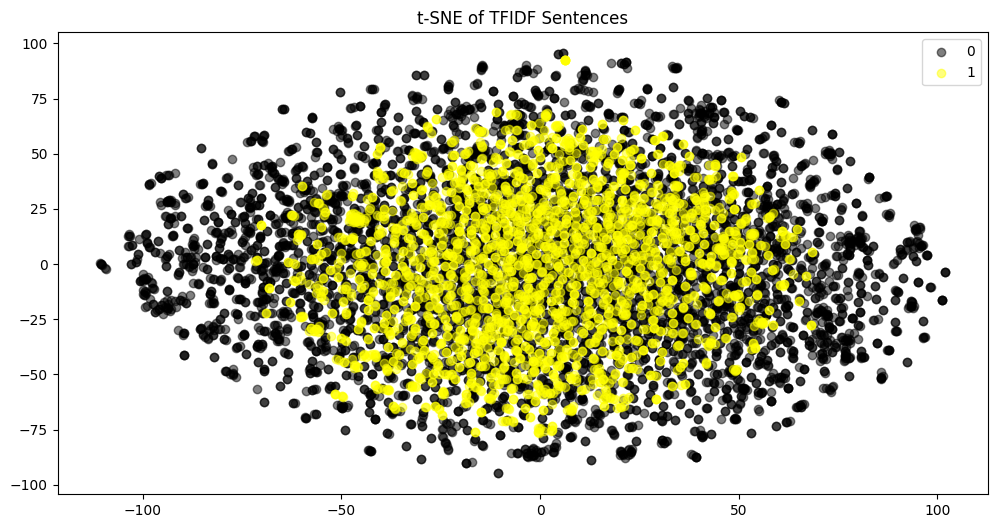

In [ ]:
print(f"Number of POSITIVE comments: {len(positive_sentences)}")
print(f"Number of NEGATIVE comments: {len(negative_sentences)}")

# Plot t-SNE for positive sentences
plt.figure(figsize=(12, 6))
plt.scatter(tsne_negative[:, 0], tsne_negative[:, 1], c='black', alpha=0.5, label=0)
plt.scatter(tsne_positive[:, 0], tsne_positive[:, 1], c='yellow', alpha=0.5, label=1)
plt.legend()
plt.title('t-SNE of TFIDF Sentences')
plt.show()

#### 4) Apply an ML model of your choice over both representations and comment.

In [ ]:
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models


# Initialize Word2Vec model
w2v_model = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, sg=1)

# Function to convert a BERT-tokenized sentence to a vector using Word2Vec
def sentence_to_vec(tokenized_sentence, w2v_model):
    vecs = [w2v_model.wv[word] for sentence in tokenized_sentence for word in sentence if word in w2v_model.wv]
    if len(vecs) > 0:
        return np.mean(vecs, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)


# Convert sentences to vectors
X = np.array([sentence_to_vec(tokenized_sentences, w2v_model) for sentence in df['sentence']])
y = np.array(df['label'])

In [ ]:
X[5]

NameError: name 'X' is not defined

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define a simple neural network model
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(w2v_model.vector_size,)),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")